# 3) Convolutional Neural Network (CNN) and Transfer Learning
#### In this third notebook, we keep searching for models that will mimic or even surpass the performance of the **Local Contrast** (*LC*) algorithm for image quality scoring, employed in astronomical images processing. Specifically, we will **transfer** the knowledge of a pre-trained **Convolutional Neural Network, MobileNet**, to which we will add a few extra layers that will be trained. We will train the model on two classes: lowest quality subframes, and highest quality subframes of Mars. The model will be compared to the LC algorithm **quantitatively** and **qualitatively** (subjective aesthetic judgment). 

In [59]:
import planet_utils as utils
import os
import numpy as np
import tensorflow as tf
import keras.layers as tfl
from keras.utils import image_dataset_from_directory
from keras import callbacks
from keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
from PIL import Image
import IPython.display as display
import pickle

Create some necessary folders. They will be rooted in the current working directory. 

In [2]:
# Specify the name of the new folders
bad_imgs = "bad_imgs"
good_imgs = "good_imgs"
folder_test = "folder_test"
# Get the current working directory
current_directory = os.getcwd()
# Create the full paths to the new folders
test_path = os.path.join(current_directory, folder_test, 'test')
bad_imgs_path = os.path.join(current_directory, 'good_bad_imgs', bad_imgs)
good_imgs_path = os.path.join(current_directory, 'good_bad_imgs', good_imgs)
if not os.path.exists(bad_imgs_path):
    os.makedirs(bad_imgs_path)
if not os.path.exists(good_imgs_path):
    os.makedirs(good_imgs_path)
if not os.path.exists(test_path):    
    os.makedirs(test_path)

You must indicate here the path where you saved the Mars images dataset. (Large, 51206 images). The images are already quality-sorted by PIPP according to its LC quality algorithm (first images have highest quality).

In [3]:
folder_qualestimation = '/home/jorge/Desktop/mars_images/dataset/wholeset_qual/' # (This is my own folder path)

### Let us extract the data and re-familiarize with it again

In [4]:
if not(os.path.isfile('whole_arr2d.npy') and os.path.isfile('whole_images_list.pickle')):
    whole_arr2d, _ , whole_images_list = utils.folder_to_data(folder_qualestimation)
    np.save('whole_arr2d', whole_arr2d) # (Note: this will save a large .npy file)
    with open('whole_images_list.pickle', 'wb') as file:
        pickle.dump(whole_images_list, file) # Save a pickle file
else:
    whole_arr2d = np.load('whole_arr2d.npy')
    with open('whole_images_list.pickle', 'rb') as file:
        whole_images_list = pickle.load(file)

In [5]:
# Paths to all subrames. Print the first few ones
whole_images_list[:3]

['/home/jorge/Desktop/mars_images/dataset/wholeset_qual/00000_2022-11-19-1852_7-T-RGB-Mars_f06353_quality_100%.png',
 '/home/jorge/Desktop/mars_images/dataset/wholeset_qual/00001_2022-11-19-1852_7-T-RGB-Mars_f03713_quality_99.89%.png',
 '/home/jorge/Desktop/mars_images/dataset/wholeset_qual/00002_2022-11-19-1852_7-T-RGB-Mars_f06987_quality_99.76%.png']

array([[<Axes: title={'center': 'pipp_quality_scores'}>]], dtype=object)

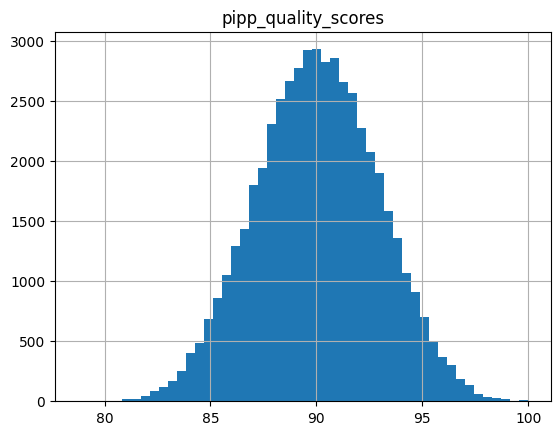

In [6]:
# Extract the PIPP quality scores (Local Contrast) from the file names, for later analysis
pipp_qual = utils.pipp_qual_parser(whole_images_list)
# Distribution of PIPP scores
pipp_df = pd.DataFrame({"pipp_quality_scores": pipp_qual})
pipp_df.hist("pipp_quality_scores", bins=50)

In [7]:
# Description of the image pixel data, from the 2D array (besides the array shape, we inspect only the first sample)
print(f'Shape: {whole_arr2d.shape}, Min: {np.min(whole_arr2d[0]):.{3}f}, Max: {np.max(whole_arr2d[0]):.{3}f}, Mean: {np.mean(whole_arr2d[0]):.{3}f}, SD: {np.std(whole_arr2d[0]):.{3}f}')

Shape: (51206, 49152), Min: 0.008, Max: 0.933, Mean: 0.209, SD: 0.247


Finally, let us display some of the highest and lowest rated subframes.

Best images vs. worst images: 


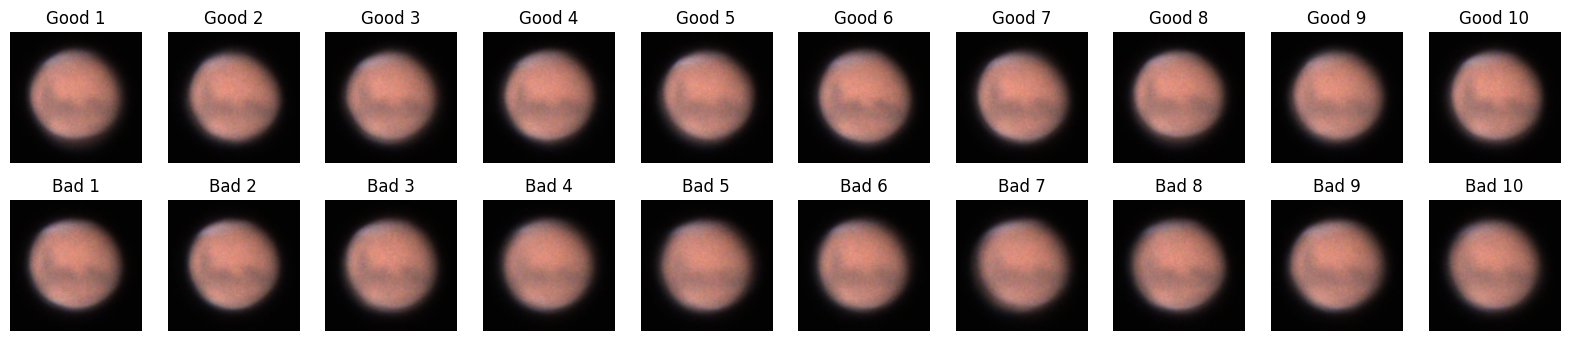

In [8]:
# Show the best and the worst 10
utils.show_best_worst(whole_images_list, show_paths=False)

### Specify training images

We make two classes of images:
- "good" (N best LC quality images)
- "bad" (N worst LC quality images)

In [9]:
N = 1000 # We might regard it as a "hyperparameter"

In [10]:
bad_imgs_arr = whole_arr2d[-N:] 
bad_imgs_paths = whole_images_list[-N:]
good_imgs_arr = whole_arr2d[:N] 
good_imgs_paths = whole_images_list[:N]

In [11]:
# Fill the folders used for training
utils.empty_folder(bad_imgs_path)
utils.empty_folder(good_imgs_path)
utils.copy_images(bad_imgs_paths, bad_imgs_path, len(bad_imgs_paths))
utils.copy_images(good_imgs_paths, good_imgs_path, len(good_imgs_paths)) 

In [12]:
# Create training and validation datasets for TensorFlow
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
directory = os.path.join(os.getcwd(), "good_bad_imgs")
train_dataset = image_dataset_from_directory(directory,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,
                                            validation_split=0.2,
                                            subset='training',
                                            seed=42)

validation_dataset = image_dataset_from_directory(directory,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,
                                            validation_split=0.2,
                                            subset='validation',
                                            seed=42)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.


2023-09-23 20:27:43.574273: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### Preprocess the images to be in the appropriate format for MobileNet, which we also load. This will be our base model.

MobileNet has already been trained on a large image dataset, ImageNet, which contains over 14 million images grouped in more than 20000 categories. We are performing **transfer learning** by reusing MobileNet's knowledge about images.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
input_shape = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                            include_top=False,
                                            weights='imagenet')

In [15]:
# # Show the base model architecture
# for i,layer in enumerate(base_model.layers):
#   print(i,layer.name)

In [16]:
# print("Summary of Mobilenet")
# base_model.summary()

### Extend the base model.

We will freeze (i.e., not re-train) MobileNet's layers and add a few extra more. When we later train the model, weight updating will take place only on these additional layers. This way, the whole model will start its training with already a generic knowledge about images, but will then specialize in high and low quality images of Mars.   

In [17]:
# Freezing all layers
for layer in base_model.layers:
    layer.trainable=False

In [18]:
# # Freeze a only a certain number of layers
# num_frozen = 20
# for layer in base_model.layers[:num_frozen]:
#     layer.trainable=False

In [19]:
inputs = tf.keras.Input(shape=input_shape)
x = preprocess_input(inputs)
x = base_model(x, training=False) 
x = tfl.GlobalAveragePooling2D()(x)
x = tfl.Dense(1024,activation='relu')(x) # Dense layer 1
x = tfl.Dropout(.2)(x) 
x = tfl.Dense(524,activation='relu')(x) # Dense layer 2
x = tfl.Dropout(.6)(x) 
x = tfl.Dense(256,activation='relu')(x) # Dense layer 3
x = tfl.Dropout(.8)(x)
outputs = tfl.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
# model.summary()

### Model hyperparameters and training

In [21]:
# Learning rate
lr = 0.0001

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])

In [23]:
num_epochs = 100 # (Early stopping might be enabled)

In [24]:
# Early stopping to avoid too much overfit
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 6, restore_best_weights = True)

Epoch 1/100


50/50 [==============================] - 9s 123ms/step - loss: 0.9267 - accuracy: 0.5169 - val_loss: 0.6785 - val_accuracy: 0.5500
Epoch 2/100
50/50 [==============================] - 5s 101ms/step - loss: 0.7513 - accuracy: 0.5269 - val_loss: 0.6685 - val_accuracy: 0.6000
Epoch 3/100
50/50 [==============================] - 5s 98ms/step - loss: 0.7029 - accuracy: 0.5656 - val_loss: 0.6599 - val_accuracy: 0.6400
Epoch 4/100
50/50 [==============================] - 5s 98ms/step - loss: 0.6895 - accuracy: 0.5825 - val_loss: 0.6501 - val_accuracy: 0.6200
Epoch 5/100
50/50 [==============================] - 5s 96ms/step - loss: 0.6688 - accuracy: 0.5913 - val_loss: 0.6427 - val_accuracy: 0.6175
Epoch 6/100
50/50 [==============================] - 5s 93ms/step - loss: 0.6439 - accuracy: 0.6200 - val_loss: 0.6213 - val_accuracy: 0.6575
Epoch 7/100
50/50 [==============================] - 5s 96ms/step - loss: 0.6318 - accuracy: 0.6363 - val_loss: 0.6042 - val_accuracy: 0.6825
Epoch 8/100
50/5

/home/jorge/Desktop/Code/planet_quality_ranking/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


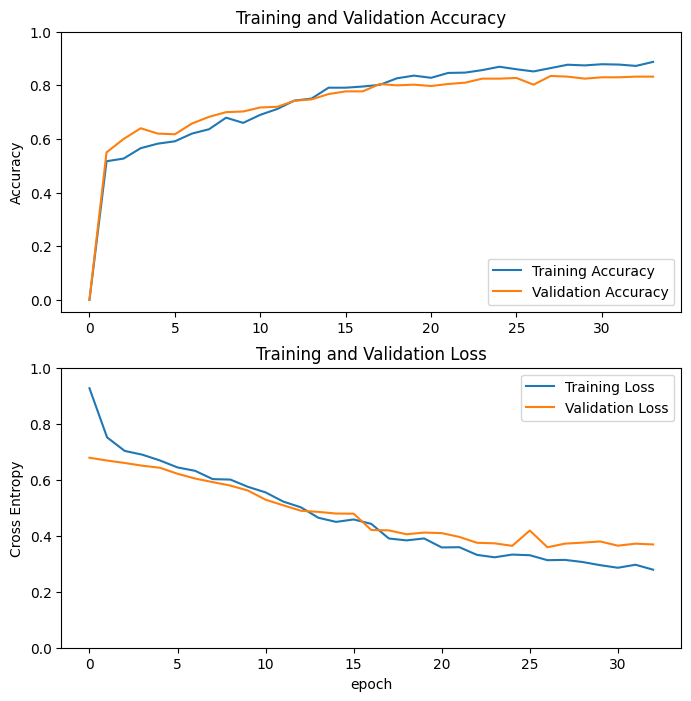

In [25]:
# Train and save model. (Comment out this cell to load a saved model).
history = model.fit(train_dataset, validation_data=validation_dataset, shuffle=False, epochs=num_epochs, callbacks =[earlystopping])
# Save the model, weights included
model.save('cnn_model.h5')
# Plot loss and accuracy over the epochs
utils.loss_accuracy_plot(history)

In [26]:
# # Load model. (Comment out this cell if we are training a new model).
# model = load_model('cnn_model.h5')

We obtained very high training and validity accuracies, which indicates that the model learned the dataset well. However, the training dataset was based on the extreme Local Contrast scores. Let us see how the model behaves with a more representative subset of the data.   

### Comparison of model and Local Contrast algorithm

As in the previous notebooks, we will operate for now on a smaller subset of the data, which will speed up our exploration of the data.

In [27]:
# Select random images for folder_test
test_path_list = sorted(utils.random_selection(folder_qualestimation, 5000))

In [28]:
# Create the smaller, representative dataset
utils.empty_folder(test_path)
utils.copy_images(test_path_list, test_path, len(test_path_list)) 
test_dataset = image_dataset_from_directory(os.path.join(os.getcwd(), folder_test),
                                            shuffle=False, 
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,
                                            seed=42)

Found 5000 files belonging to 1 classes.


In [29]:
# Model's "scores" (probability of belonging to the "goood images" class) for each image
predictions = model.predict(test_dataset, batch_size=BATCH_SIZE)
predictions = (np.round_(predictions, decimals = 4)).squeeze()
model_test_dict = {key: value for key, value in zip(test_path_list, predictions)}
model_test_sorted_paths = sorted(model_test_dict.keys(), key=lambda x: model_test_dict[x], reverse=True)

157/157 [==============================] - 14s 82ms/step


In [30]:
# Get PIPP score for each image
pipp_scores = utils.pipp_qual_parser(test_path_list)

We now have all we need to compare the LC's and the model's image quality scores.

In [31]:
data_df = pd.DataFrame({'pipp_scores': pipp_scores, 'model_qual': predictions})

In [32]:
data_df.describe()

pipp_scores   model_qual
count  5000.000000  5000.000000
mean     90.075184     0.520088
std       2.930027     0.358748
min      80.710000     0.000800
25%      88.040000     0.137975
50%      90.090000     0.561850
75%      92.110000     0.885425
max      99.890000     0.996300

<Axes: xlabel='pipp_scores', ylabel='model_qual'>

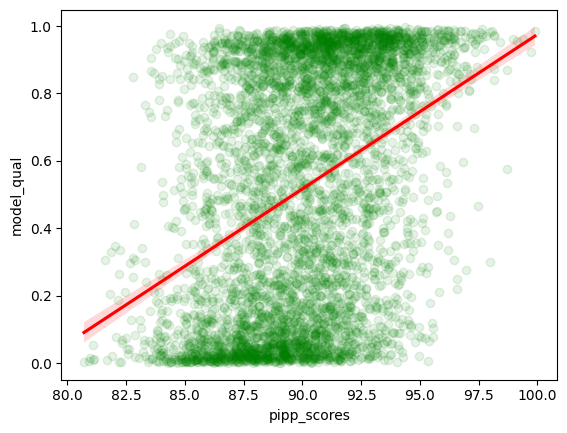

In [33]:
sns.regplot(x='pipp_scores', y='model_qual', data=data_df, scatter_kws={"color": "green", 'alpha': 0.1}, line_kws={"color": "red"})

We can see that the model's quality estimations tend to increase together with PIPP's. But very importantly, the model has a strong tendency to classify the images as either "very bad" or "very good". Let us look at the distribution of the model's score estimations to further confirm this:

<Axes: >

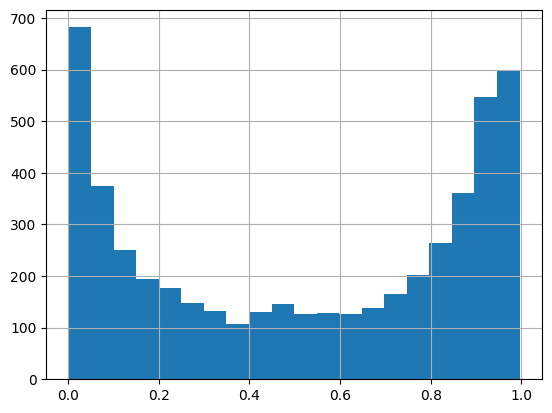

In [34]:
data_df['model_qual'].hist(bins=20)

The shape of this distribution is quite different from the LC's (as we saw above), which looked like a normal distribution. Looking at the training results, the small difference in accuracy between training set and validation set indicates that there was no significant overfitting. However, this statement holds only for that training (and validation) dataset, which was composed of extreme quality values. It is no surprise ,therefore, that the model will tend to classify "intermediate-level" images as either very bad or very good.   

We will now calculate Spearman's correlation as a quantitative measure of the similarity between the two scoring systems. Spearman's correlation should be more appropriate than Pearson's correlation in this case, given that the former does not make assumptions about the form of the variables' relationship (it only assesses monotonicity). 

In [35]:
# Spearman's correlation
data_df['pipp_scores'].corr(data_df['model_qual'], method='spearman')

0.38366197412036795

We found a moderate correlation.

But, as in the previous notebooks, what interests me the most is the ordering of the images according to subjective aesthetic quality. Does the model surpass the Local Contrast algorithm in this respect? 

PIPP  vs.  Model


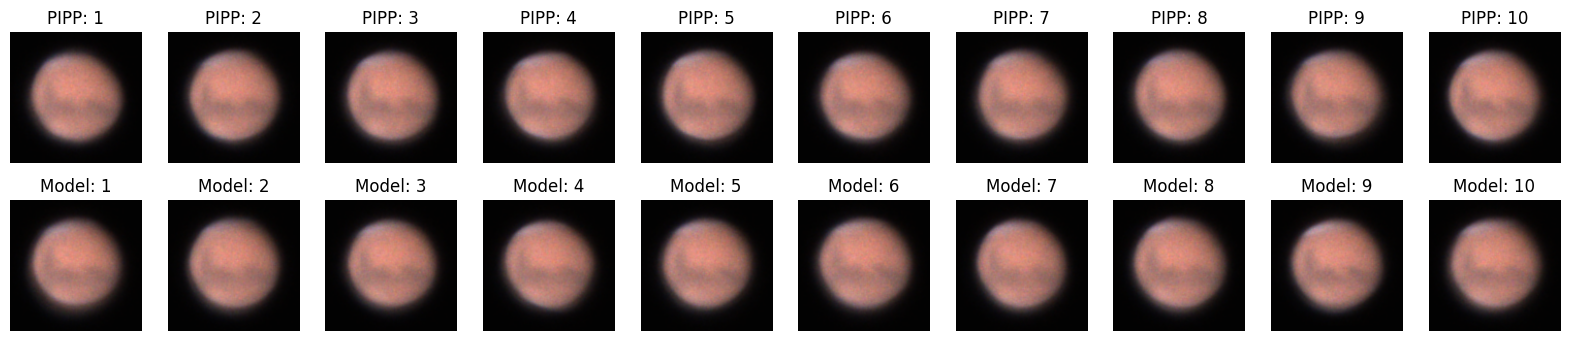

PIPP  vs.  Model


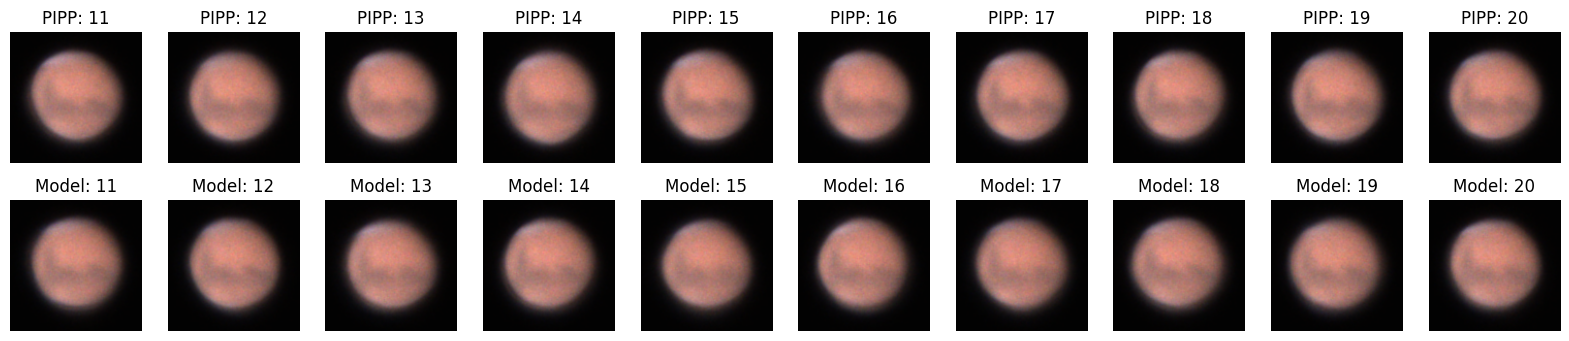

PIPP  vs.  Model


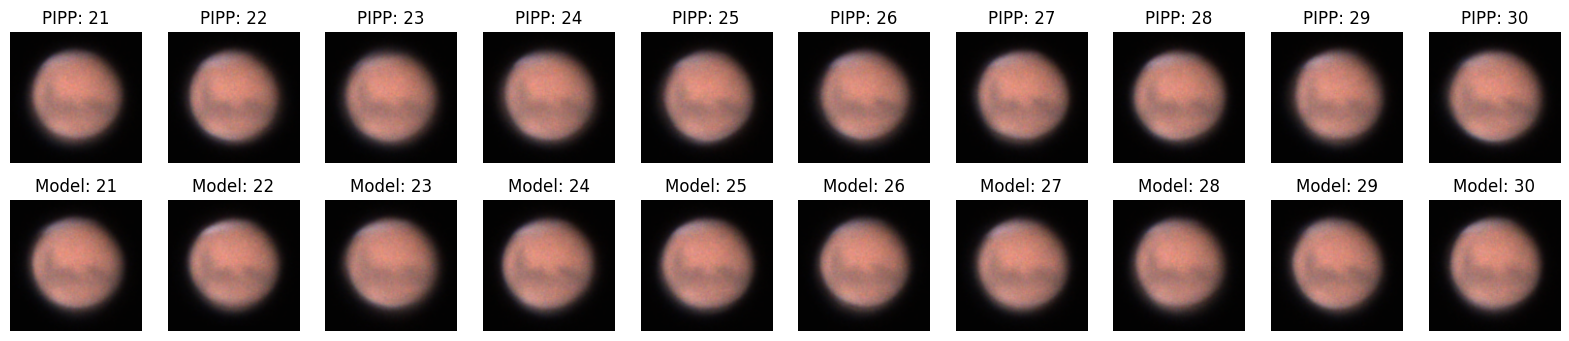

In [36]:
# When running this cell, press <Enter> to get a subsequent subset of 10 best quality images.
# Press <q>, followed by <Enter>, to stop the function. 
utils.images_compare(test_path_list, 'PIPP', model_test_sorted_paths, 'Model', 10)

This is only a casual visual inspection. But, in any case, I don't feel any difference in favor nor against the model's quality ordering when comparing it to the LC (PIPP) algorithm. I will not further process these images. 

### Underfitted model

After trying many different settings, I noticed that underfitting this model actually provided better aesthetic results. (A discussion about this can be found in the Readme file.) 

Let us repeat the previous procedure, but this time training the model with very few epochs. 

In [37]:
# Freezing all layers
for layer in base_model.layers:
    layer.trainable=False
    
inputs = tf.keras.Input(shape=input_shape)
x = preprocess_input(inputs)
x = base_model(x, training=False) 
x = tfl.GlobalAveragePooling2D()(x)
x = tfl.Dense(1024,activation='relu')(x) # Dense layer 1
x = tfl.Dropout(.2)(x) 
x = tfl.Dense(524,activation='relu')(x) # Dense layer 2
x = tfl.Dropout(.6)(x) 
x = tfl.Dense(256,activation='relu')(x) # Dense layer 3
x = tfl.Dropout(.8)(x)
outputs = tfl.Dense(1, activation='sigmoid')(x)
underfitted = tf.keras.Model(inputs, outputs)

In [38]:
# model.summary()

In [39]:
# Learning rate
lr = 0.0001

In [40]:
underfitted.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])

In [41]:
num_epochs = 3 # (Only 3 epochs!)

In [42]:
# Early stopping to avoid too much overfit
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 6, restore_best_weights = True)

Epoch 1/3


50/50 [==============================] - 8s 116ms/step - loss: 0.9867 - accuracy: 0.5094 - val_loss: 0.6723 - val_accuracy: 0.5925
Epoch 2/3
50/50 [==============================] - 5s 99ms/step - loss: 0.7826 - accuracy: 0.5269 - val_loss: 0.6643 - val_accuracy: 0.6450
Epoch 3/3
50/50 [==============================] - 5s 94ms/step - loss: 0.7166 - accuracy: 0.5525 - val_loss: 0.6560 - val_accuracy: 0.6050


/home/jorge/Desktop/Code/planet_quality_ranking/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


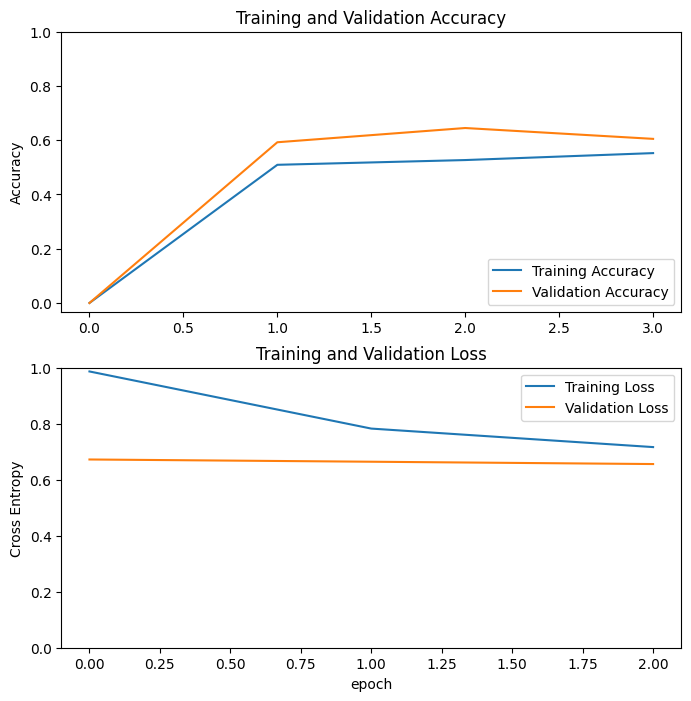

In [43]:
# Train and save model. (Comment out this cell to load a saved model).
history = underfitted.fit(train_dataset, validation_data=validation_dataset, shuffle=False, epochs=num_epochs, callbacks =[earlystopping])
# Save the model, weights included
underfitted.save('underfitted_cnn_model.h5')
# Plot loss and accuracy over the epochs
utils.loss_accuracy_plot(history)

In [44]:
# # Load model. (Comment out this cell if we are training a new model).
# model = load_model('cnn_model.h5')

The training and validation accuracies barely had time to go up.

In [45]:
# Model's "scores" (probability of belonging to the "goood images" class) for each image
predictions = underfitted.predict(test_dataset, batch_size=BATCH_SIZE)
predictions = (np.round_(predictions, decimals = 4)).squeeze()
model_test_dict = {key: value for key, value in zip(test_path_list, predictions)}
model_test_sorted_paths = sorted(model_test_dict.keys(), key=lambda x: model_test_dict[x], reverse=True)

157/157 [==============================] - 12s 72ms/step


In [46]:
# Get PIPP score for each image
pipp_scores = utils.pipp_qual_parser(test_path_list)

In [47]:
data_df = pd.DataFrame({'pipp_scores': pipp_scores, 'model_qual': predictions})

In [48]:
data_df.describe()

pipp_scores   model_qual
count  5000.000000  5000.000000
mean     90.075184     0.459733
std       2.930027     0.069083
min      80.710000     0.186200
25%      88.040000     0.416900
50%      90.090000     0.468300
75%      92.110000     0.511200
max      99.890000     0.621200

<Axes: xlabel='pipp_scores', ylabel='model_qual'>

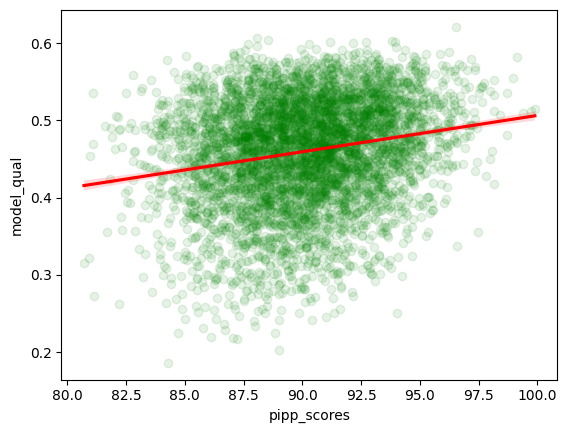

In [49]:
sns.regplot(x='pipp_scores', y='model_qual', data=data_df, scatter_kws={"color": "green", 'alpha': 0.1}, line_kws={"color": "red"})

<Axes: >

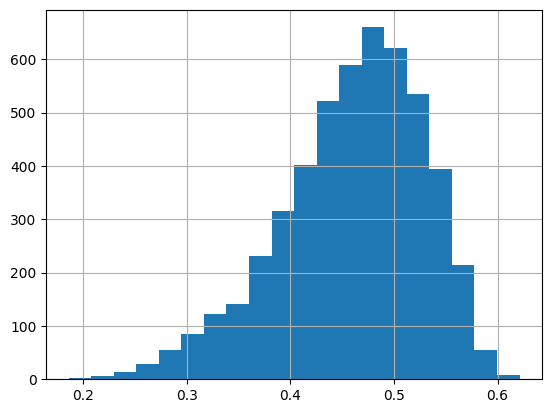

In [50]:
data_df['model_qual'].hist(bins=20)

The last few figures show us how the model didn't even "bother" to cover the whole probability range between 0 and 1.

In [51]:
# Spearman's correlation
data_df['pipp_scores'].corr(data_df['model_qual'], method='spearman')

0.18463235720255855

Spearman's correlation between PIPP scores and the model's quality probabilities is very low. The model does not seem to agree much with the Local Contrast algorithm.

Regarding our qualitative assessment, let us this time use directly the whole dataset.

In [52]:
whole_dataset = image_dataset_from_directory(os.path.abspath(os.path.join(os.path.dirname(folder_qualestimation), os.pardir)),
                                            shuffle=False,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,
                                            seed=42)

Found 51206 files belonging to 1 classes.


In [53]:
whole_predictions = underfitted.predict(whole_dataset, batch_size=BATCH_SIZE)
print("predictions size: ", len(whole_predictions))
whole_paths = whole_dataset.file_paths

1601/1601 [==============================] - 115s 72ms/step
predictions size:  51206


In [54]:
# From PIPP:
PIPP_whole_paths = sorted([os.path.join(folder_qualestimation, img) for img in os.listdir(folder_qualestimation)])

In [55]:
# From model predictions:
whole_predictions = np.round_(whole_predictions, decimals = 4)
model_whole_dict = {key: value for key, value in zip(PIPP_whole_paths, whole_predictions)}
model_whole_sorted_paths = sorted(model_whole_dict.keys(), key=lambda x: model_whole_dict[x], reverse=True)

PIPP  vs.  Model


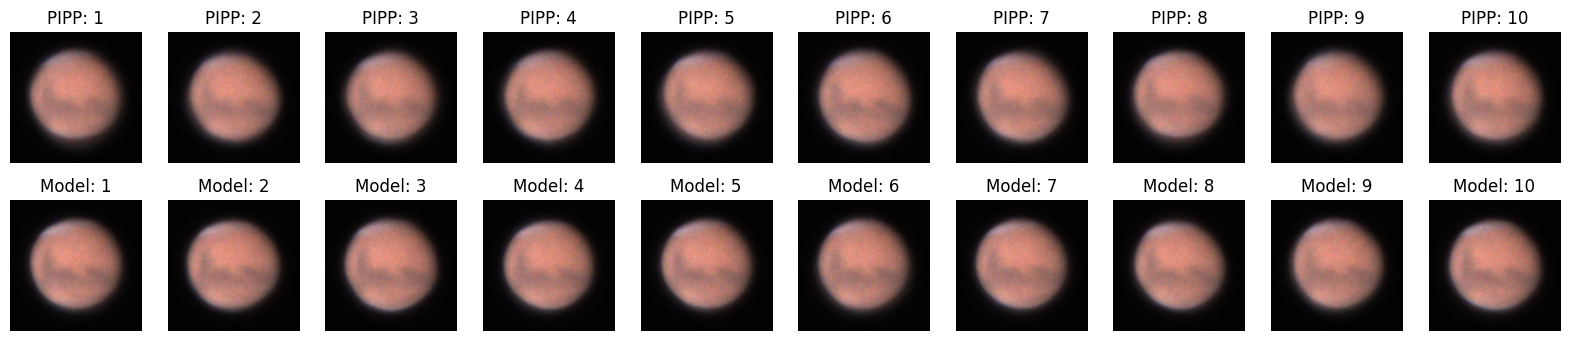

PIPP  vs.  Model


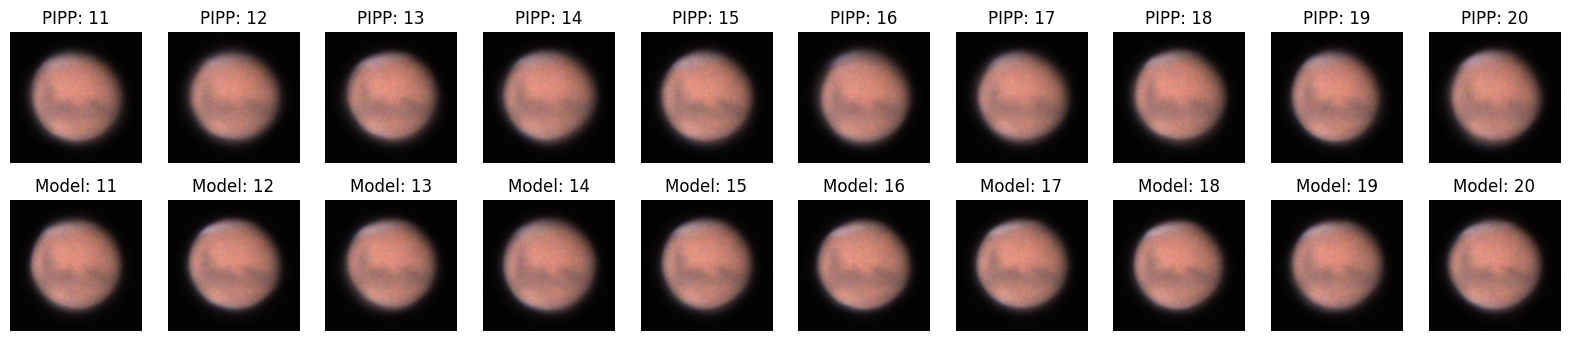

PIPP  vs.  Model


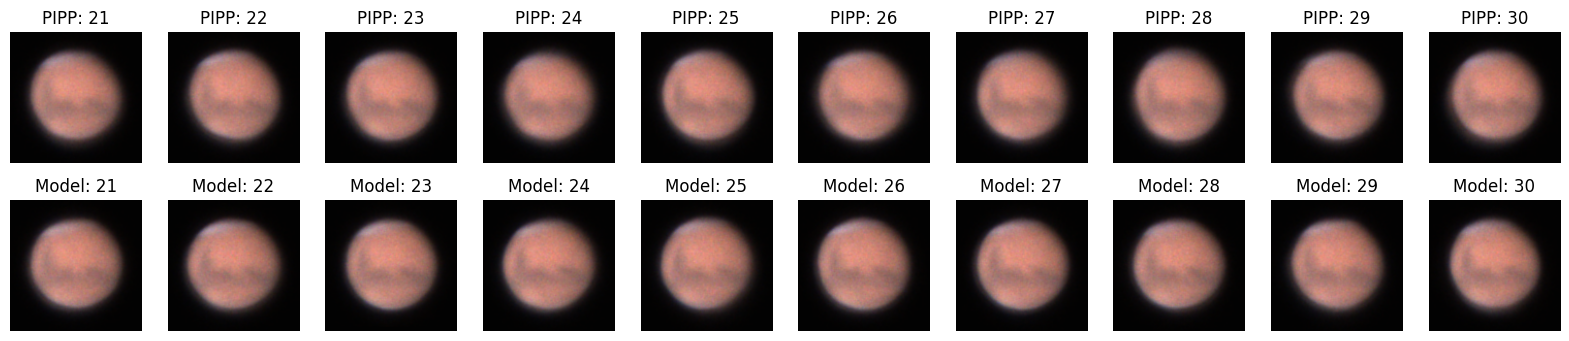

In [56]:
# When running this cell, press <Enter> to get a subsequent subset of 10 best quality images.
# Press <q>, followed by <Enter>, to stop the function. 
utils.images_compare(PIPP_whole_paths, 'PIPP', model_whole_sorted_paths, 'Model', 10) 

Personally, I feel that this second CNN model quality-sorts the images better than the previous model and much better than the LC algorithm. We can see how, practically without exception, each model's "good image" looks better than its LC's counterpart. Images are sharper, the black regions and the clouds are more defined, and there is more consistency across the images in terms of aesthetic quality. 
Let us stack the images for a final verdict.

In [60]:
# # All the following creates copies of the N best images in folders, to stack them and process with other software.
# # Uncomment if you want to proceed with further processing.  

# pipp_stacking = "pipp_stacking"
# model_stacking = "model_stacking"
# current_directory = os.getcwd()
# pipp_stacking_path = os.path.join(current_directory, pipp_stacking)
# model_stacking_path = os.path.join(current_directory, model_stacking)
# if not os.path.exists(pipp_stacking_path):    
#     os.makedirs(pipp_stacking_path)
# if not os.path.exists(model_stacking_path):    
#     os.makedirs(model_stacking_path)
# num_stack = 2000
# utils.empty_folder(pipp_stacking_path)
# utils.empty_folder(model_stacking_path)
# utils.copy_images(PIPP_whole_paths, pipp_stacking_path, num_stack) 
# utils.copy_images(model_whole_sorted_paths, model_stacking_path, num_stack) 

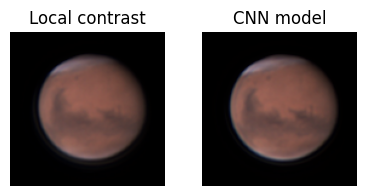

In [61]:
lc_stacked = mpimg.imread(os.path.join(os.getcwd(), 'pipp_stacked.png'))
cnn_model_stacked = mpimg.imread(os.path.join(os.getcwd(), 'cnn_model_stacked.png'))
utils.display_two_img(lc_stacked, 'Local contrast', cnn_model_stacked, 'CNN model')

After stacking the best 2000 images and sharpening them with the same settings, our model clearly yields a sharper, more defined image. Let us now compare this image to the other one we obtained in the first notebook using a "trick" on linear regression, which also appeared to surpass LC quality scoring.  

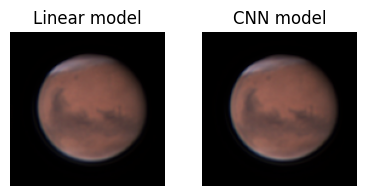

In [62]:
lin_stacked = mpimg.imread(os.path.join(os.getcwd(), 'lin_model_stacked.png'))
cnn_model_stacked = mpimg.imread(os.path.join(os.getcwd(), 'cnn_model_stacked.png'))
utils.display_two_img(lin_stacked, 'Linear model', cnn_model_stacked, 'CNN model')

The difference is smaller in this case, but I personally find the CNN model image superior to the linear model's. 

### Conclusion

We extended a MobileNet Convolutional Neural Network and trained it on two classes of images, namely, PIPP's lower and and higher quality images of Mars. Letting the CNN network train for longer epochs resulted in a model with an image quality ranking that correlated moderately with the one from PIPP's Local Contrast algorithm, but the CNN model appeared not to offer (or barely) a aesthetically superior ranking. However, if we dramatically undertrain the network, the situation becomes the reverse, helping to yield what I personally feel are much better images. (Further discussion in the Readme file). 

I would also like to note that we have kept the image processing settings constant for the three images (the one from PIPP alone; that from linear model in the first notebook; and the last one here), so that we can fairly compare them with each other. The three are based on stacks of the best 2000 images, respectively, which come from a large dataset of more than 50000 images. The last CNN model had the good characteristic of being very consistent in terms of aesthetic quality ranking (i.e., when we inspect the quality-sorted images within a given range, they tend to have all the same degree of aesthetic quality; this was not the case at all with the Local Contrast ranking). This implies that we can afford to stack more images by using the CNN model: it will find many "gems" throughout the whole dataset, which the LC algorithm may not have always given a high score; and it will have less "bad images" interspersed throughout the top ranking. More (good) images to stack imply a higher noise reduction, which results in a better final processed image. 

As a matter of fact, I obtained my best Mars image (the one used for the coefficients mask in the first notebook) by using this model for image quality ranking before stacking (see again, below).

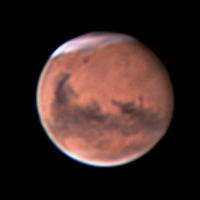

In [63]:
image = Image.open(os.path.join(os.getcwd(), 'mars_processed.png'))
display.display(image.resize((200, 200)))